In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, accuracy_score, f1_score,  precision_score, recall_score, confusion_matrix, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

d:\CS 6120\Final Project\cs6010_fa2024_project_g06\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# List of relevant columns
columns_to_use = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 
                  'trip_distance','RatecodeID', 'PULocationID','DOLocationID','payment_type','fare_amount']

In [4]:
df2024_1 = pd.read_parquet('../data/raw/yellow_tripdata_2024-01.parquet', columns=columns_to_use)
df2024_2 = pd.read_parquet('../data/raw/yellow_tripdata_2024-02.parquet', columns=columns_to_use)
df2024_3 = pd.read_parquet('../data/raw/yellow_tripdata_2024-03.parquet', columns=columns_to_use)
df2024_4 = pd.read_parquet('../data/raw/yellow_tripdata_2024-04.parquet', columns=columns_to_use)
df2024_5 = pd.read_parquet('../data/raw/yellow_tripdata_2024-05.parquet', columns=columns_to_use)
df2024_6 = pd.read_parquet('../data/raw/yellow_tripdata_2024-06.parquet', columns=columns_to_use)

df2024 = pd.concat([df2024_1, df2024_2, df2024_3, df2024_4, df2024_5, df2024_6])

In [5]:
df2024.shape

(20332093, 9)

In [6]:
df2024.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
count,20332093,20332093,1.835611e+07,2.033209e+07,1.835611e+07,2.033209e+07,2.033209e+07,2.033209e+07,2.033209e+07
mean,2024-04-04 15:46:48.415694,2024-04-04 16:03:41.511144,1.332897e+00,4.704865e+00,2.226112e+00,1.647972e+02,1.638971e+02,1.102157e+00,1.888715e+01
min,2002-12-31 16:46:07,2002-12-31 17:24:07,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.285400e+03
25%,2024-02-21 21:43:17,2024-02-21 21:56:08,1.000000e+00,1.020000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,9.300000e+00
50%,2024-04-05 20:57:06,2024-04-05 21:11:56,1.000000e+00,1.750000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.350000e+01
75%,2024-05-18 02:57:44,2024-05-18 03:10:54,1.000000e+00,3.300000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.190000e+01
max,2026-06-26 23:53:12,2026-06-27 20:59:10,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,3.340763e+05
std,NaN,NaN,8.304837e-01,3.592496e+02,1.053827e+01,6.434706e+01,6.954032e+01,6.315719e-01,7.728530e+01


In [7]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    'null_value(%)': df2024.isna().mean().values * 100,
    'neg_value(%)': [len(df2024[col][df2024[col] < 0]) / len(df2024) * 100 if col in df2024.select_dtypes(include=[np.number]).columns else 0 for col in df2024.columns],
    '0_value(%)': [len(df2024[col][df2024[col] == 0]) / len(df2024) * 100 if col in df2024.select_dtypes(include=[np.number]).columns else 0 for col in df2024.columns],
    'duplicate' : df2024.duplicated().sum(),
    'min': [df2024[col].min() if col in df2024.select_dtypes(include=[np.number]).columns else None for col in df2024.columns],
    'max': [df2024[col].max() if col in df2024.select_dtypes(include=[np.number]).columns else None for col in df2024.columns],
    'n_unique': df2024.nunique().values,
    'sample_unique': [df2024[col].unique() for col in df2024.columns]}
).round(3)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,min,max,n_unique,sample_unique
0,tpep_pickup_datetime,datetime64[us],0.000,0.000,0.000,913,NaN,NaN,9955675,"[2024-01-01 00:57:55, 2024-01-01 00:03:00, 202..."
1,tpep_dropoff_datetime,datetime64[us],0.000,0.000,0.000,913,NaN,NaN,9948395,"[2024-01-01 01:17:43, 2024-01-01 00:09:36, 202..."
2,passenger_count,float64,9.719,0.000,1.087,913,0.0,9.00,10,"[1.0, 2.0, 0.0, 4.0, 3.0, 5.0, 6.0, 8.0, 7.0, ..."
3,trip_distance,float64,0.000,0.000,1.792,913,0.0,312722.30,7056,"[1.72, 1.8, 4.7, 1.4, 0.8, 10.82, 3.0, 5.44, 0..."
4,RatecodeID,float64,9.719,0.000,0.000,913,1.0,99.00,7,"[1.0, 5.0, 2.0, 4.0, 99.0, 3.0, 6.0, nan]"
5,PULocationID,int32,0.000,0.000,0.000,913,1.0,265.00,262,"[186, 140, 236, 79, 211, 148, 138, 246, 161, 1..."
6,DOLocationID,int32,0.000,0.000,0.000,913,1.0,265.00,261,"[79, 236, 211, 148, 141, 181, 231, 261, 113, 1..."
7,payment_type,int64,0.000,0.000,9.719,913,0.0,5.00,6,"[2, 1, 4, 3, 0, 5]"
8,fare_amount,float64,0.000,1.553,0.041,913,-1285.4,334076.32,14681,"[17.7, 10.0, 23.3, 7.9, 29.6, 45.7, 25.4, 31.0..."


In [8]:
df2024.reset_index(drop=True, inplace=True)

In [9]:
#check memory usage
df2024.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20332093 entries, 0 to 20332092
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int32         
 6   DOLocationID           int32         
 7   payment_type           int64         
 8   fare_amount            float64       
dtypes: datetime64[us](2), float64(4), int32(2), int64(1)
memory usage: 1.2 GB


## EDA

In [10]:
# fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20,15))
# index = 0
# axs = axs.flatten()
# for k, v in df2024.select_dtypes(include=[np.number]).items():
#     sns.boxplot(y=k, data=df2024, ax=axs[index])
#     index += 1
# plt.tight_layout(w_pad=0.5, h_pad=2)

Based on the boxplot above, it can be concluded that the dataset contains many outliers and none of them are normally distributed.

In [11]:
# fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
# index = 0
# axs = axs.flatten()
# for k, v in df2024_1.select_dtypes(include=[np.number]).items():
#     axs[index].set_title(k)
#     sns.displot(x=df2024[k], ax=axs[index])
#     index += 1
# plt.tight_layout(w_pad=0.5, h_pad=2)
# plt.show()

In [12]:
# plt.figure(figsize=(10,6))
# sns.heatmap(df2024.corr('spearman'), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
# plt.show()

## Data Cleaning

In [13]:
df2024[df2024.duplicated()]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
6956,2024-01-01 01:53:45,2024-01-01 02:25:58,1.0,2.97,1.0,170,50,2,0.0
15731,2024-01-01 02:15:52,2024-01-01 02:46:49,2.0,8.86,1.0,246,133,2,0.0
20848,2024-01-01 04:28:12,2024-01-01 04:28:27,1.0,0.00,5.0,265,265,2,0.0
20850,2024-01-01 04:29:46,2024-01-01 04:30:01,1.0,0.00,5.0,265,265,2,0.0
40344,2024-01-01 14:57:35,2024-01-01 14:57:46,1.0,0.00,1.0,132,132,2,0.0
...,...,...,...,...,...,...,...,...,...
19892496,2024-06-30 16:41:41,2024-06-30 16:41:55,1.0,0.03,2.0,80,256,2,0.0
19893852,2024-06-30 16:46:29,2024-06-30 17:51:54,2.0,19.10,2.0,142,132,2,0.0
19898808,2024-06-30 17:53:49,2024-06-30 17:53:56,4.0,0.00,5.0,132,132,2,0.0
19899442,2024-06-30 17:24:58,2024-06-30 17:25:47,4.0,0.00,1.0,43,236,2,0.0


In [14]:
df2024.drop_duplicates(inplace= True)

In [15]:
duplicate_value = df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)]
duplicate_value

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
99,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,249,232,4,-13.50
100,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,249,232,4,13.50
506,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,5.0,63,63,2,-31.50
507,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,5.0,63,63,2,31.50
536,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,1.0,249,113,4,-5.80
...,...,...,...,...,...,...,...,...,...
20134261,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,NaN,50,186,0,19.48
20165058,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,NaN,151,74,0,18.92
20165469,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,NaN,231,68,0,17.37
20198683,2024-06-21 18:55:00,2024-06-21 19:11:00,NaN,2.21,NaN,234,163,0,18.11


In [16]:
dup_negative_val = duplicate_value[duplicate_value['fare_amount']<0]
dup_negative_val 

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
99,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,249,232,4,-13.5
506,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,5.0,63,63,2,-31.5
536,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,1.0,249,113,4,-5.8
552,2024-01-01 00:42:02,2024-01-01 01:14:33,1.0,5.48,1.0,107,61,2,-33.1
682,2024-01-01 00:24:02,2024-01-01 01:10:32,1.0,8.74,1.0,90,225,4,-47.8
...,...,...,...,...,...,...,...,...,...
19921136,2024-06-30 23:03:55,2024-06-30 23:12:30,3.0,0.91,1.0,230,162,4,-6.5
19921164,2024-06-30 23:47:55,2024-07-01 00:36:20,2.0,5.38,1.0,186,256,4,-43.6
19921257,2024-06-30 23:19:00,2024-06-30 23:54:15,2.0,17.77,2.0,132,230,4,-70.0
19921287,2024-06-30 23:47:08,2024-06-30 23:47:13,1.0,0.00,5.0,138,138,3,-86.0


In [17]:
df2024.drop(dup_negative_val.index, inplace=True)

In [18]:
df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
171767,2024-01-03 12:57:37,2024-01-03 12:57:43,1.0,0.00,1.0,195,195,2,3.00
665102,2024-01-09 07:11:33,2024-01-09 07:16:51,1.0,0.60,1.0,68,246,1,6.50
701034,2024-01-09 14:25:35,2024-01-09 14:32:45,1.0,0.79,1.0,48,142,2,7.90
720867,2024-01-09 17:43:44,2024-01-09 17:47:10,1.0,0.53,1.0,141,141,1,5.80
785990,2024-01-10 14:25:58,2024-01-10 14:35:57,1.0,1.39,1.0,162,164,1,10.70
...,...,...,...,...,...,...,...,...,...
20062103,2024-06-09 12:40:00,2024-06-09 13:06:00,NaN,4.54,NaN,116,142,0,27.44
20113258,2024-06-14 18:49:00,2024-06-14 19:05:00,NaN,2.60,NaN,162,239,0,20.86
20134261,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,NaN,50,186,0,19.48
20165469,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,NaN,231,68,0,17.37


In [19]:
df2024.drop_duplicates(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,186,79,2,17.70
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,140,236,1,10.00
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,236,79,1,23.30
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,79,211,1,10.00
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,211,148,1,7.90
...,...,...,...,...,...,...,...,...,...
20332088,2024-06-30 23:07:36,2024-06-30 23:18:35,NaN,2.51,NaN,255,148,0,21.09
20332089,2024-06-30 23:46:07,2024-07-01 00:11:53,NaN,7.55,NaN,68,74,0,33.96
20332090,2024-06-30 23:18:50,2024-06-30 23:35:09,NaN,4.25,NaN,41,100,0,21.01
20332091,2024-06-30 23:33:36,2024-06-30 23:42:37,NaN,1.60,NaN,158,231,0,14.41


In [20]:
df2024.shape

(20074971, 9)

In [21]:
df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
171767,2024-01-03 12:57:37,2024-01-03 12:57:43,1.0,0.00,1.0,195,195,2,3.00
665102,2024-01-09 07:11:33,2024-01-09 07:16:51,1.0,0.60,1.0,68,246,1,6.50
701034,2024-01-09 14:25:35,2024-01-09 14:32:45,1.0,0.79,1.0,48,142,2,7.90
720867,2024-01-09 17:43:44,2024-01-09 17:47:10,1.0,0.53,1.0,141,141,1,5.80
785990,2024-01-10 14:25:58,2024-01-10 14:35:57,1.0,1.39,1.0,162,164,1,10.70
...,...,...,...,...,...,...,...,...,...
20062103,2024-06-09 12:40:00,2024-06-09 13:06:00,NaN,4.54,NaN,116,142,0,27.44
20113258,2024-06-14 18:49:00,2024-06-14 19:05:00,NaN,2.60,NaN,162,239,0,20.86
20134261,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,NaN,50,186,0,19.48
20165469,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,NaN,231,68,0,17.37


In [22]:
print(df2024.index.duplicated().sum())

0


In [23]:
df2024.reset_index(drop=True, inplace=True)

In [24]:
print(df2024.index.duplicated().sum())

0


In [25]:
df2024.shape

(20074971, 9)

In [26]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'neg_value(%)': [len(df2024[col][df2024[col] < 0]) / len(df2024) * 100 if np.issubdtype(df2024[col].dtype, np.number) else 0 for col in df2024.columns]
}).round(3)

,feature,neg_value(%)
0,tpep_pickup_datetime,0.000
1,tpep_dropoff_datetime,0.000
2,passenger_count,0.000
3,trip_distance,0.000
4,RatecodeID,0.000
5,PULocationID,0.000
6,DOLocationID,0.000
7,payment_type,0.000
8,fare_amount,0.297


In [27]:
negative_val  = df2024[df2024['fare_amount']<0]
df2024.loc[negative_val.index, 'fare_amount'] = df2024['fare_amount'].abs()

In [28]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    '0_value(%)': [len(df2024[col][df2024[col] == 0]) / len(df2024) * 100 if np.issubdtype(df2024[col].dtype, np.number) else 0 for col in df2024.columns]
}).round(3)

,feature,data_type,0_value(%)
0,tpep_pickup_datetime,datetime64[us],0.000
1,tpep_dropoff_datetime,datetime64[us],0.000
2,passenger_count,float64,1.101
3,trip_distance,float64,1.700
4,RatecodeID,float64,0.000
5,PULocationID,int32,0.000
6,DOLocationID,int32,0.000
7,payment_type,int64,9.843
8,fare_amount,float64,0.037


In [29]:
median_passenger_count = df2024[df2024['passenger_count'] > 0]['passenger_count'].median()
df2024['passenger_count'] = df2024['passenger_count'].apply(lambda x: x if (x > 0 )  else median_passenger_count)

df2024 = df2024[df2024['trip_distance']>0]
df2024 = df2024[df2024['fare_amount']>0]

In [30]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    'null_value(%)': df2024.isna().mean().values * 100
}).round(3)

,feature,data_type,null_value(%)
0,tpep_pickup_datetime,datetime64[us],0.000
1,tpep_dropoff_datetime,datetime64[us],0.000
2,passenger_count,float64,0.000
3,trip_distance,float64,0.000
4,RatecodeID,float64,9.375
5,PULocationID,int32,0.000
6,DOLocationID,int32,0.000
7,payment_type,int64,0.000
8,fare_amount,float64,0.000


In [31]:
df2024['passenger_count'].fillna(df2024['passenger_count'].median(), inplace=True)
df2024['passenger_count'].value_counts()

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_19152\2787419272.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2024['passenger_count'].fillna(df2024['passenger_count'].median(), inplace=True)


passenger_count
1.0    15899768
2.0     2584114
3.0      593074
4.0      341857
5.0      184933
6.0      124979
8.0          67
7.0          14
9.0          10
Name: count, dtype: int64

In [32]:
outliers = df2024[(df2024['tpep_pickup_datetime'].dt.year!=2024)]
outliers

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
255,2023-12-31 23:56:46,2024-01-01 00:12:06,2.0,2.38,1.0,236,142,1,15.6
368,2023-12-31 23:39:17,2023-12-31 23:42:00,2.0,0.47,1.0,90,68,1,5.1
748,2023-12-31 23:41:02,2023-12-31 23:48:03,1.0,0.40,1.0,246,246,2,7.2
2193,2023-12-31 23:57:17,2024-01-01 00:01:50,1.0,0.53,1.0,144,211,1,5.8
2593,2023-12-31 23:56:45,2024-01-01 00:00:28,1.0,0.97,1.0,163,237,1,6.5
2962,2023-12-31 23:49:12,2024-01-01 00:04:32,1.0,3.14,1.0,234,237,1,17.0
3151,2023-12-31 23:47:28,2023-12-31 23:57:07,2.0,1.44,1.0,68,137,1,10.7
4095,2023-12-31 23:58:35,2024-01-01 00:13:06,6.0,8.39,1.0,138,217,2,33.1
4100,2023-12-31 23:58:37,2024-01-01 00:08:37,2.0,0.59,1.0,161,170,1,10.0
8521,2023-12-31 23:54:27,2024-01-01 00:13:12,1.0,7.70,1.0,229,244,1,33.1


In [33]:
df2024.drop(outliers.index, inplace=True)

In [34]:
df2024[(df2024['tpep_pickup_datetime'].dt.year!=2024)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount


In [35]:
# time_bins = [0, 5, 11, 15, 20, 24] 
# time_labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Night']
# df2024['pickup_time'] = pd.cut(df2024['tpep_pickup_datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False)

# df2024['day_category'] = df2024['tpep_pickup_datetime'].dt.day_name().apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekdays')

In [36]:
df2024 = df2024[df2024['trip_distance']>1]

In [37]:
df2024[df2024['trip_distance']>120].sort_values(by='trip_distance', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
2922580,2024-01-30 06:37:00,2024-01-30 06:50:00,1.0,312722.30,NaN,151,162,0,14.46
12876491,2024-04-26 21:08:00,2024-04-26 21:29:00,1.0,270766.80,NaN,162,231,0,29.22
12639980,2024-04-08 05:19:00,2024-04-08 05:22:00,1.0,268958.23,NaN,137,229,0,8.08
16440015,2024-05-18 21:21:00,2024-05-18 21:31:00,1.0,249151.44,NaN,231,113,0,16.30
16548064,2024-05-28 08:45:00,2024-05-28 09:26:00,1.0,241289.24,NaN,25,162,0,57.03


In [38]:
df2024 = df2024[df2024['trip_distance']<120]

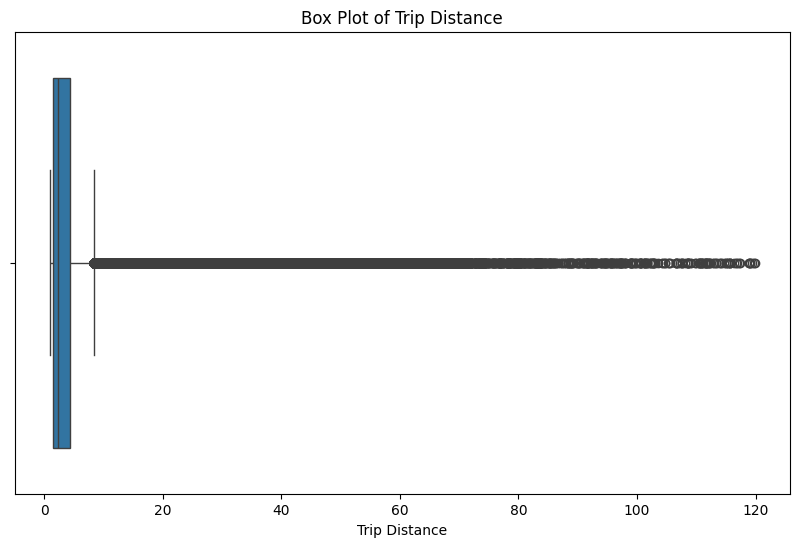

In [39]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2024['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

In [40]:
df2024[df2024['fare_amount']>120].sort_values(by='fare_amount', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
1144345,2024-01-14 10:08:11,2024-01-16 13:54:22,1.0,31.95,1.0,220,220,2,2221.3
4613185,2024-02-18 14:13:36,2024-02-18 14:16:18,1.0,1.07,5.0,218,218,4,999.0
5374572,2024-02-26 19:18:19,2024-02-27 15:33:07,1.0,36.20,1.0,193,193,2,924.9
10171773,2024-04-08 07:19:52,2024-04-08 10:48:19,1.0,115.63,4.0,64,265,2,873.1
5669444,2024-02-29 17:06:32,2024-02-29 20:08:18,5.0,118.87,4.0,132,265,2,821.3


In [41]:
diff = (df2024['tpep_dropoff_datetime'] - df2024['tpep_pickup_datetime']).dt.total_seconds()/60
df2024['trip_duration'] = diff.round(2)

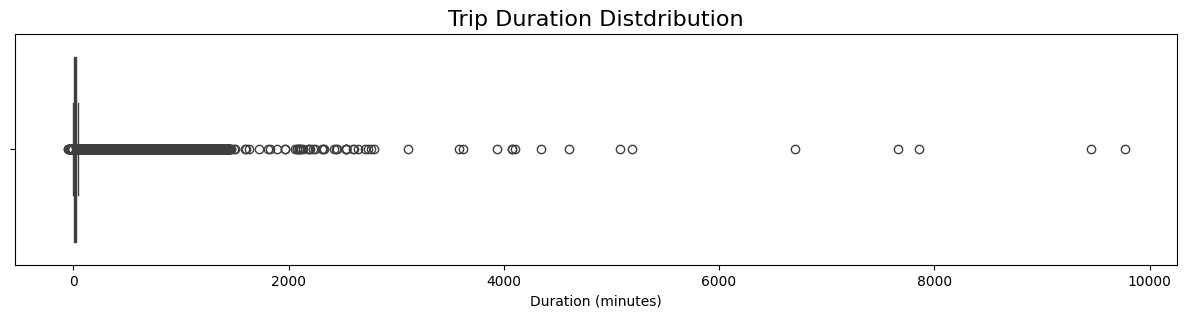

In [42]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2024, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

In [43]:
diff = (df2024['tpep_dropoff_datetime'] - df2024['tpep_pickup_datetime']).dt.total_seconds()/60
df2024['trip_duration'] = diff.round(2)

In [44]:
df2024[df2024['trip_duration']>700].sort_values(by='trip_duration', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,trip_duration
10249929,2024-04-08 23:16:11,2024-04-15 18:03:42,1.0,13.62,5.0,129,138,2,1.0,9767.52
2084742,2024-01-24 17:03:14,2024-01-31 06:38:38,1.0,2.26,1.0,237,170,2,30.3,9455.40
13878607,2024-05-09 19:03:38,2024-05-15 06:05:29,1.0,14.62,2.0,132,132,2,70.0,7861.85
17182170,2024-06-06 16:18:13,2024-06-11 23:56:51,1.0,8.19,1.0,138,138,2,55.5,7658.63
11884128,2024-04-24 21:36:24,2024-04-29 13:23:38,1.0,11.26,1.0,132,50,2,43.6,6707.23


In [45]:
df2024 = df2024[df2024['trip_duration']<700]

In [46]:
df2024 = df2024[df2024['trip_duration']>0]

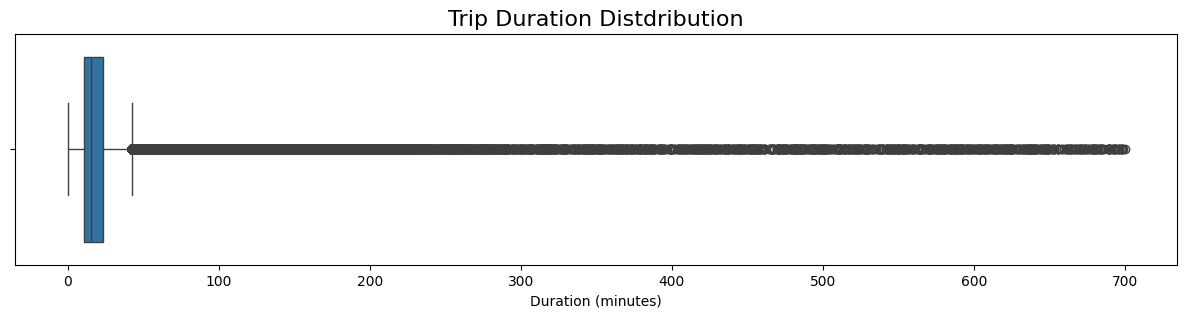

In [47]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2024, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

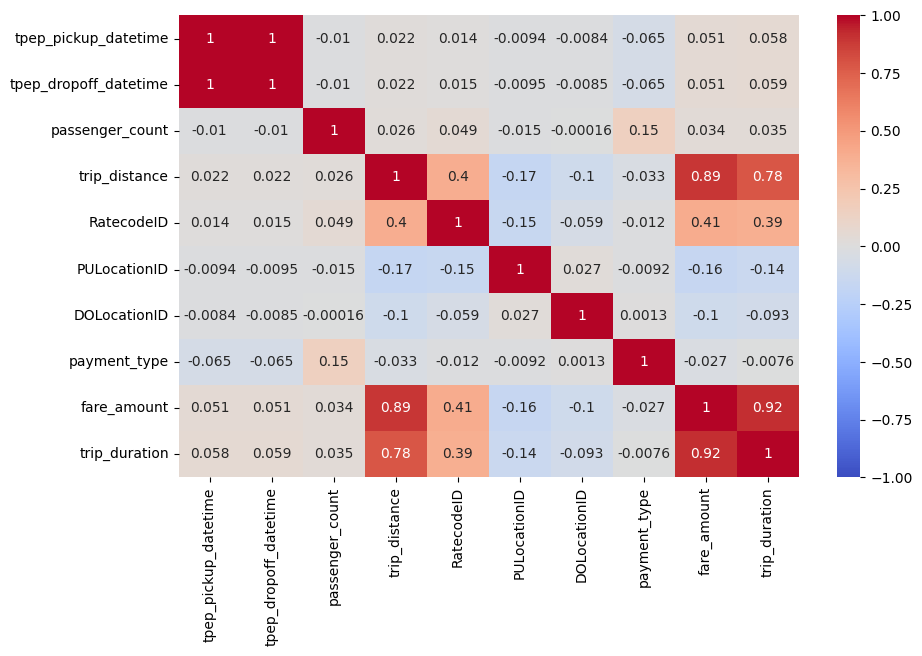

In [48]:
plt.figure(figsize=(10,6))
sns.heatmap(df2024.corr('spearman'), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.show()

In [49]:
# Extract hour, day of the week, month, and season from pickup datetime
df2024['hour'] = df2024['tpep_pickup_datetime'].dt.hour
df2024['day_of_week'] = df2024['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df2024['month'] = df2024['tpep_pickup_datetime'].dt.month

## Regression

In [50]:
df2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15165513 entries, 0 to 20074970
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int32         
 6   DOLocationID           int32         
 7   payment_type           int64         
 8   fare_amount            float64       
 9   trip_duration          float64       
 10  hour                   int32         
 11  day_of_week            int32         
 12  month                  int32         
dtypes: datetime64[us](2), float64(5), int32(5), int64(1)
memory usage: 1.3 GB


In [51]:
# Cross-validation function for regression
def cross_validate_models(X, y):
    # Initialize models
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso": Lasso(alpha=1.0),  # Adjust alpha if needed
        "Ridge": Ridge(alpha=1.0),  # Adjust alpha if needed
        "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5)  # Adjust alpha and l1_ratio if needed
    }

    results = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Cross-validation with cross_val_score for RMSE
        scores_rmse = cross_val_score(model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
        mean_cv_rmse = -np.mean(scores_rmse)  # Convert from negative RMSE to positive
        
        # Cross-validation predictions
        y_pred = cross_val_predict(model, X, y, cv=kfold)
        
        # Compute metrics
        rmse_pred = root_mean_squared_error(y, y_pred)
        mae_pred = mean_absolute_error(y, y_pred)
        r2_pred = r2_score(y, y_pred)
        
        # Store results
        results.append({
            "Model": name,
            "Cross_val_score_RMSE": mean_cv_rmse,
            "Cross_val_predict_RMSE": rmse_pred,
            "Cross_val_predict_MAE": mae_pred,
            "Cross_val_predict_R2": r2_pred
        })
        pd.DataFrame(results)
    
    return pd.DataFrame(results)

In [52]:
X = df2024.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime','RatecodeID','PULocationID','DOLocationID'])
y = df2024['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
results_df = cross_validate_models(X, y)
results_df

,Model,Cross_val_score_RMSE,Cross_val_predict_RMSE,Cross_val_predict_MAE,Cross_val_predict_R2
0,Linear Regression,5.761043,5.761083,2.570330,0.898725
1,Lasso,5.775584,5.775621,2.552154,0.898213
2,Ridge,5.761043,5.761083,2.570330,0.898725
3,ElasticNet,5.799762,5.799794,2.489469,0.897359


In [53]:

# Function for cross-validation with hyperparameter tuning
def cross_validate_models_with_hyperparams(X, y):
    # Define models and their hyperparameter grids
    model_params = {
        "Linear Regression": {
            "model": LinearRegression(),
            "params": {}  # No hyperparameters to tune for Linear Regression
        },
        "Lasso": {
            "model": Lasso(),
            "params": {"alpha": [0.001, 0.01, 0.1, 1, 10]}  # Hyperparameter: alpha
        },
        "Ridge": {
            "model": Ridge(),
            "params": {"alpha": [0.001, 0.01, 0.1, 1, 10]}  # Hyperparameter: alpha
        },
        "ElasticNet": {
            "model": ElasticNet(),
            "params": {
                "alpha": [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
                "l1_ratio": [0.1, 0.5, 0.7, 0.9]     # Balance between L1 and L2
            }
        }
    }

    results = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, config in model_params.items():
        model = config["model"]
        param_grid = config["params"]
        
        # Perform GridSearchCV if hyperparameters exist
        if param_grid:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, 
                                       scoring='neg_root_mean_squared_error', n_jobs=-1)
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = model
            best_params = "Default (No hyperparams)"
        
        # Cross-validation with the best model
        scores_rmse = cross_val_score(best_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
        mean_cv_rmse = -np.mean(scores_rmse)  # Convert from negative RMSE to positive
        
        # Cross-validation predictions
        y_pred = cross_val_predict(best_model, X, y, cv=kfold)
        
        # Compute metrics
        rmse_pred = root_mean_squared_error(y, y_pred)
        mae_pred = mean_absolute_error(y, y_pred)
        r2_pred = r2_score(y, y_pred)
        
        # Store results
        results.append({
            "Model": name,
            "Best_Params": best_params,
            "Cross_val_score_RMSE": mean_cv_rmse,
            "Cross_val_predict_RMSE": rmse_pred,
            "Cross_val_predict_MAE": mae_pred,
            "Cross_val_predict_R2": r2_pred
        })
    
    return pd.DataFrame(results)

In [54]:
df_2024copy = df2024.copy()

In [55]:
df_2024copy['fare_amount'] = np.log1p(df_2024copy['fare_amount'])
df_2024copy['trip_distance'] = np.log1p(df_2024copy['trip_distance'])
df_2024copy['trip_duration'] = np.log1p(df_2024copy['trip_duration'])

In [56]:
X = df_2024copy.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime','RatecodeID','PULocationID','DOLocationID'])
y = df_2024copy['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
results_df = cross_validate_models(X, y)
results_df

KeyboardInterrupt: 

In [ ]:

# Function for cross-validation with hyperparameter tuning
def cross_validate_models_with_hyperparams(X, y):
    # Define models and their hyperparameter grids
    model_params = {
        "Linear Regression": {
            "model": LinearRegression(),
            "params": {}  # No hyperparameters to tune for Linear Regression
        },
        "Lasso": {
            "model": Lasso(),
            "params": {"alpha": np.logspace(-3, 1, 5)}  # Hyperparameter: alpha
        },
        "Ridge": {
            "model": Ridge(),
            "params": {"alpha": np.logspace(-3, 1, 5)}  # Hyperparameter: alpha
        },
        "ElasticNet": {
            "model": ElasticNet(),
            "params": {
                "alpha": np.logspace(-3, 1, 5),  # Regularization strength
                "l1_ratio": [0.1, 0.5, 0.9]     # Balance between L1 and L2
            }
        }
    }

    results = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, config in model_params.items():
        model = config["model"]
        param_grid = config["params"]
        
        # Perform GridSearchCV if hyperparameters exist
        if param_grid:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, 
                                       scoring='neg_root_mean_squared_error', n_jobs=-1)
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = model
            best_params = "Default (No hyperparams)"
        
        # Cross-validation with the best model
        scores_rmse = cross_val_score(best_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
        mean_cv_rmse = -np.mean(scores_rmse)  # Convert from negative RMSE to positive
        
        # Cross-validation predictions
        y_pred = cross_val_predict(best_model, X, y, cv=kfold)
        
        # Compute metrics
        rmse_pred = root_mean_squared_error(y, y_pred)
        mae_pred = mean_absolute_error(y, y_pred)
        r2_pred = r2_score(y, y_pred)
        
        # Store results
        results.append({
            "Model": name,
            "Best_Params": best_params,
            "Cross_val_score_RMSE": mean_cv_rmse,
            "Cross_val_predict_RMSE": rmse_pred,
            "Cross_val_predict_MAE": mae_pred,
            "Cross_val_predict_R2": r2_pred
        })
    
    return pd.DataFrame(results)

In [ ]:
# Import additional metrics
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score

# Function for cross-validation with hyperparameter tuning and additional metrics
def cross_validate_models_with_hyperparams(X, y):
    # Define models and their hyperparameter grids
    model_params = {
        "Linear Regression": {
            "model": LinearRegression(),
            "params": {}  # No hyperparameters to tune for Linear Regression
        },
        "Lasso": {
            "model": Lasso(),
            "params": {"alpha": np.logspace(-3, 1, 5)}  # Hyperparameter: alpha
        },
        "Ridge": {
            "model": Ridge(),
            "params": {"alpha": np.logspace(-3, 1, 5)}  # Hyperparameter: alpha
        },
        "ElasticNet": {
            "model": ElasticNet(),
            "params": {
                "alpha": np.logspace(-3, 1, 5),  # Regularization strength
                "l1_ratio": [0.1, 0.5, 0.9]     # Balance between L1 and L2
            }
        }
    }

    results = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, config in model_params.items():
        model = config["model"]
        param_grid = config["params"]
        
        # Perform GridSearchCV if hyperparameters exist
        if param_grid:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, 
                                       scoring='neg_root_mean_squared_error', n_jobs=-1)
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = model
            best_params = "Default (No hyperparams)"
        
        # Cross-validation with the best model
        scores_rmse = cross_val_score(best_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
        mean_cv_rmse = -np.mean(scores_rmse)  # Convert from negative RMSE to positive
        
        # Cross-validation predictions
        y_pred = cross_val_predict(best_model, X, y, cv=kfold)
        
        # Compute metrics
        rmse_pred = root_mean_squared_error(y, y_pred)
        mae_pred = mean_absolute_error(y, y_pred)
        mape_pred = mean_absolute_percentage_error(y, y_pred)
        r2_pred = r2_score(y, y_pred)
        evs_pred = explained_variance_score(y, y_pred)
        
        # Store results
        results.append({
            "Model": name,
            "Best_Params": best_params,
            "Cross_val_score_RMSE": mean_cv_rmse,
            "Cross_val_predict_RMSE": rmse_pred,
            "Cross_val_predict_MAE": mae_pred,
            "Cross_val_predict_MAPE": mape_pred,
            "Cross_val_predict_R2": r2_pred,
            "Cross_val_predict_EVS": evs_pred
        })
    
    return pd.DataFrame(results)

# Example usage
metrics_df = cross_validate_models_with_hyperparams(X, y)
print(metrics_df)


In [ ]:
df_2024copyStandardized = df_2024copy.copy()
scaler = StandardScaler()
X = df_2024copyStandardized.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime','RatecodeID','PULocationID','DOLocationID'])
y = df_2024copyStandardized['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
X = scaler.fit_transform(X)
results_df = cross_validate_models(X, y)
results_df

In [ ]:
X = df2024.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime','RatecodeID','PULocationID','DOLocationID'])
y = df2024['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
results_df = cross_validate_models_with_hyperparams(X, y)
results_df

In [ ]:
df2024.info()

In [ ]:
X = df2024.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime','RatecodeID','PULocationID','DOLocationID'])
y = df2024['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
results_df = cross_validate_models_with_hyperparams(X, y)
results_df

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_19152\1284455130.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Cross_val_score_RMSE', data=df, palette='viridis', ax=axs[0, 0])
C:\Users\ujjwa\AppData\Local\Temp\ipykernel_19152\1284455130.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Cross_val_predict_MAE', data=df, palette='viridis', ax=axs[0, 1])
C:\Users\ujjwa\AppData\Local\Temp\ipykernel_19152\1284455130.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Cross_val_predict_R2', data=df, 

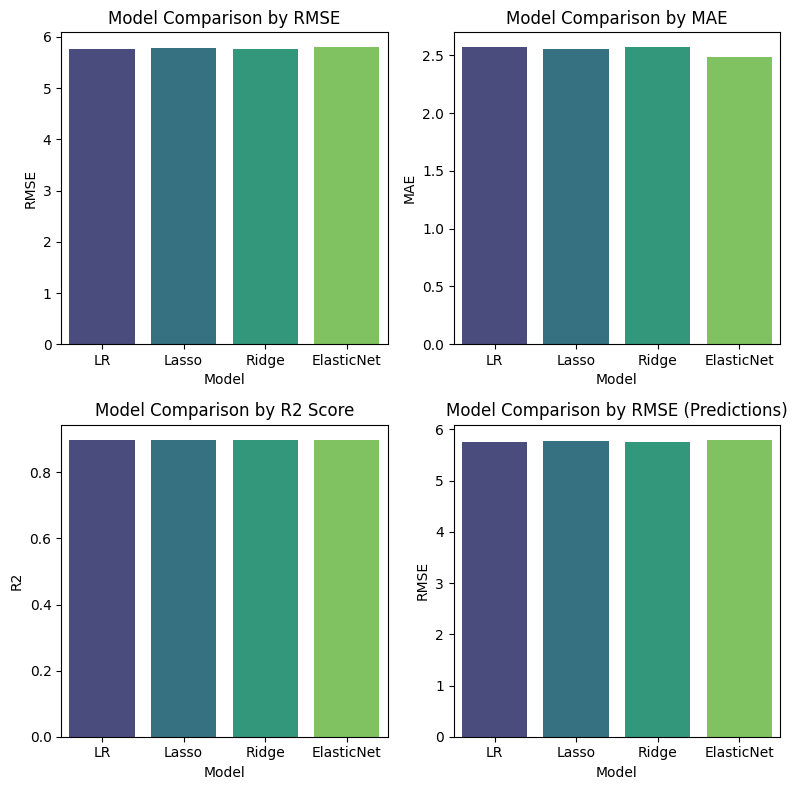

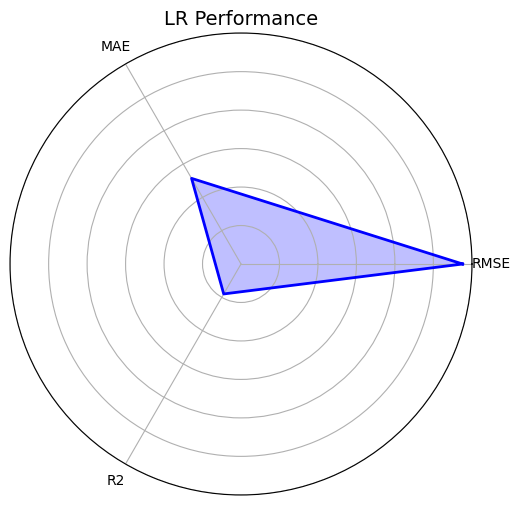

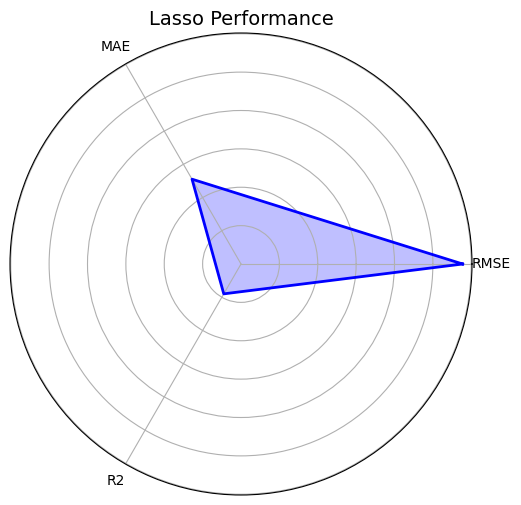

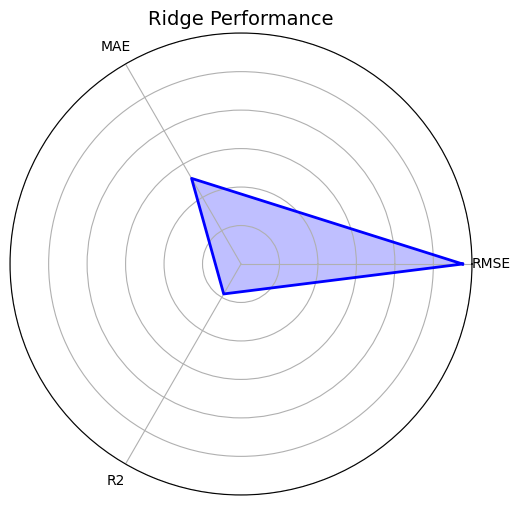

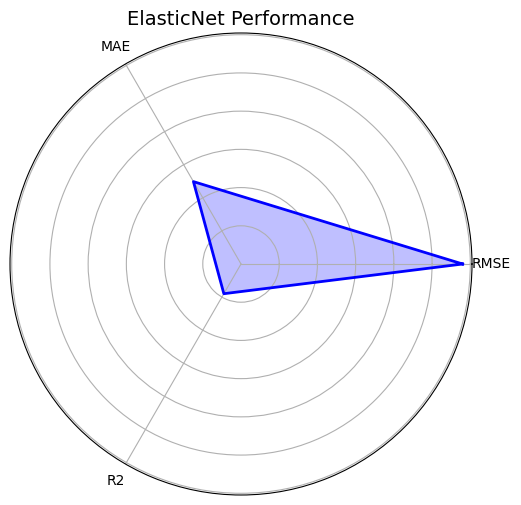

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create the DataFrame
data = {
    'Model': ['LR', 'Lasso', 'Ridge', 'ElasticNet'],
    'Cross_val_score_RMSE': [5.761043, 5.775584, 5.761043, 5.799762],
    'Cross_val_predict_RMSE': [5.761083, 5.775621, 5.761083, 5.799794],
    'Cross_val_predict_MAE': [2.570330, 2.552154, 2.570330, 2.489469],
    'Cross_val_predict_R2': [0.898725, 0.898213, 0.898725, 0.897359]
}

df = pd.DataFrame(data)

# 1. Create the 2x2 grid of bar charts

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# RMSE Bar Chart
sns.barplot(x='Model', y='Cross_val_score_RMSE', data=df, palette='viridis', ax=axs[0, 0])
axs[0, 0].set_title('Model Comparison by RMSE')
axs[0, 0].set_ylabel('RMSE')

# MAE Bar Chart
sns.barplot(x='Model', y='Cross_val_predict_MAE', data=df, palette='viridis', ax=axs[0, 1])
axs[0, 1].set_title('Model Comparison by MAE')
axs[0, 1].set_ylabel('MAE')

# R2 Score Bar Chart
sns.barplot(x='Model', y='Cross_val_predict_R2', data=df, palette='viridis', ax=axs[1, 0])
axs[1, 0].set_title('Model Comparison by R2 Score')
axs[1, 0].set_ylabel('R2')

# Optional - Second RMSE comparison (or any other metric you prefer)
sns.barplot(x='Model', y='Cross_val_predict_RMSE', data=df, palette='viridis', ax=axs[1, 1])
axs[1, 1].set_title('Model Comparison by RMSE (Predictions)')
axs[1, 1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

# 2. Radar Chart for model comparison

def radar_chart(data, categories, title):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    values = data.tolist()
    
    values += values[:1]  # Repeat the first value to close the circle
    angles += angles[:1]  # Repeat the first angle to close the circle
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)  # Line plot
    
    ax.set_yticklabels([])  # Hide the radial ticks
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(title, size=14)
    plt.show()

# Radar chart for each model's performance
categories = ['RMSE', 'MAE', 'R2']
for model in df['Model']:
    model_data = df[df['Model'] == model][['Cross_val_score_RMSE', 'Cross_val_predict_MAE', 'Cross_val_predict_R2']].values.flatten()
    radar_chart(model_data, categories, f'{model} Performance')



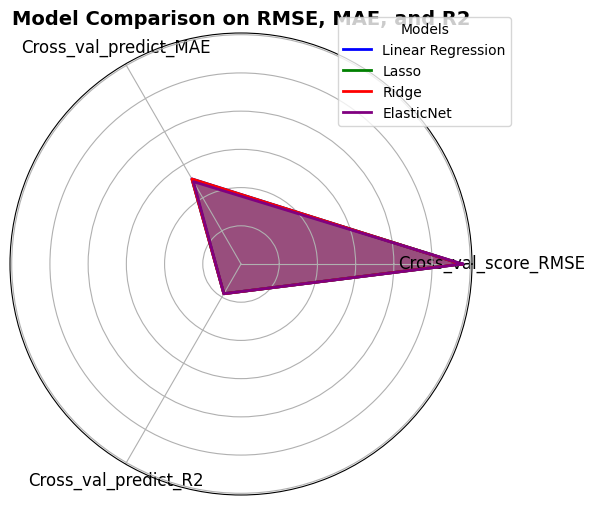

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Create the DataFrame
data = {
    'Model': ['Linear Regression', 'Lasso', 'Ridge', 'ElasticNet'],
    'Cross_val_score_RMSE': [5.761043, 5.775584, 5.761043, 5.799762],
    'Cross_val_predict_RMSE': [5.761083, 5.775621, 5.761083, 5.799794],
    'Cross_val_predict_MAE': [2.570330, 2.552154, 2.570330, 2.489469],
    'Cross_val_predict_R2': [0.898725, 0.898213, 0.898725, 0.897359]
}

df = pd.DataFrame(data)

# Radar Chart Function (Single Radar for All Models)
def radar_chart_all_models(df, categories, title):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()  # Equal angles for each metric
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Loop through each model and plot its data
    colors = ['blue', 'green', 'red', 'purple']  # Colors for each model
    for idx, model in enumerate(df['Model']):
        model_data = df[df['Model'] == model][categories].values.flatten()
        model_data = np.concatenate((model_data, [model_data[0]]))  # To close the radar chart loop
        angle = np.concatenate((angles, [angles[0]]))  # Close the loop
        
        ax.fill(angle, model_data, color=colors[idx], alpha=0.3)  # Fill the area with opacity
        ax.plot(angle, model_data, color=colors[idx], linewidth=2, label=model)  # Plot line

    ax.set_yticklabels([])  # Remove radial ticks
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_title(title, size=14, weight='bold')

    # Add a legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05), title='Models')

    plt.show()

# Corrected categories with actual column names
categories = ['Cross_val_score_RMSE', 'Cross_val_predict_MAE', 'Cross_val_predict_R2']

# Radar chart for all models
radar_chart_all_models(df, categories, 'Model Comparison on RMSE, MAE, and R2')


In [ ]:
# Extract hour, day of the week, month, and season from pickup datetime
df2024['hour'] = df2024['tpep_pickup_datetime'].dt.hour
df2024['day_of_week'] = df2024['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df2024['month'] = df2024['tpep_pickup_datetime'].dt.month